# Brain Tumor Classification with N11 Model

## 1 Load Data
The dataset used in this example is from [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) challenge on Kaggle. 
### 1.1 Create an Annotation File
The brain MRI images are organized as the follows:
```
./brain_tumor_dataset/yes/xxx.jpg
./brain_tumor_dataset/yes/xxy.jpg
./brain_tumor_dataset/yes/xxz.jpg

./brain_tumor_dataset/no/123.jpg
./brain_tumor_dataset/no/456.jpg
./brain_tumor_dataset/no/789.jpg
```
To grab image information and store them in an comma-seperated values (CSV) file:

Visit the data directory, grab all images' paths and corresponding categories.
Save the paths and categories of images in an .csv file

In [1]:
import sys
import os
from glob import glob
import pandas as pd

# Locate train and test directories
root_dir = "./brain_tumor_dataset"  # locate dataset directory from this repo in the whole system
yes_dir = os.path.join(root_dir, "yes")
no_dir = os.path.join(root_dir, "no")
categories = ['yes', 'no']

# Glob training files
yes_files = glob(os.path.join(yes_dir, "*.*"))
no_files = glob(os.path.join(no_dir, "*.*"))
print(f"There are {len(yes_files)} images with tumors, and {len(no_files)} images without tumors in the dataset")
combined_files = yes_files + no_files
labels = ['yes'] * len(yes_files) + ['no'] * len(no_files)
data_dict = {'path': combined_files, 'label': labels}
df = pd.DataFrame(data_dict)
df.to_csv('annotation_data.csv', header=False, index=False)

# # Glob test files
# test_cat_files = glob(os.path.join(test_dir, categories[0], "*.jpg"))
# test_dog_files = glob(os.path.join(test_dir, categories[1], "*.jpg"))
# print(f"There are {len(test_cat_files)} cat images, and {len(test_dog_files)} dog images in the test dataset")
# test_image_files = test_cat_files + test_dog_files
# test_labels = ['cat'] * len(test_cat_files) + ['dog'] * len(test_dog_files)
# test_data_dict = {'path': test_image_files, 'label': test_labels}
# df_test = pd.DataFrame(test_data_dict)
# # print(df_test)
# df_test.to_csv('annotation_test.csv', header=False, index=False)

There are 155 images with tumors, and 98 images without tumors in the dataset


### 1.2 Create a Dataset using PyTorch
1. Inherit the Dataset class to build a customized TumorDetectDataset class.
2. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets.

0 (128, 128) 1
100 (128, 128) 1
200 (128, 128) 0
252 (128, 128) 0


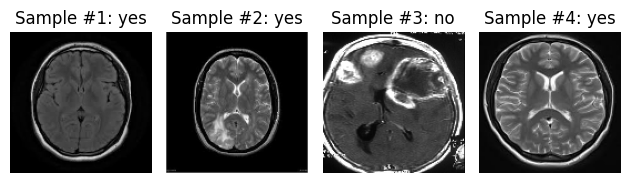

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Create customized dataset
class TumorDetectDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.imgs_info.iloc[idx, 0]
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image_raw, (128, 128))
        category = 1 if self.imgs_info.iloc[idx, 1] == 'yes' else 0
        sample = {'image': image, 'category': category}
        return sample

# Loop training dataset
dataset = TumorDetectDataset(annotations_file='annotation_data.csv')
for i, sample in enumerate(dataset):
    image = sample['image']
    category = sample['category']
    if not i%100:
        print(i, image.shape, category)
print(i, image.shape, category)
    
# Create shuffled data loader 
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
samples = next(iter(dataloader))
fig, axs = plt.subplots(1, 4)
for i in range(4):
    image = samples['image'][i]
    category = categories[samples['category'][i]]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'Sample #{i+1}: {category}')
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    plt.tight_layout()

### 1.3 Data Preprocessing

In [19]:
data_train = next(iter(dataloader))

# Separate features from targets 
raw_features_train = data_train['image'].numpy()
raw_labels_train = data_train['category'].numpy()
print(f"Raw training data shapes: {raw_features_train.shape}, {raw_labels_train.shape}")

# Reshape feature matrix to (M, width*height*3), target vector to (M, 1)
reshaped_features_train = raw_features_train.reshape(raw_features_train.shape[0], -1)
reshaped_labels_train = raw_labels_train.reshape(-1, 1)
# Rescale features within range: 0~1
rescaled_features_train = reshaped_features_train / 255

# Finalize data to be used later
features_train = rescaled_features_train
labels_train = reshaped_labels_train


# Sanity check
print(f"Processed training features shape: {features_train.shape}")
print(f"Processed training labels shape: {labels_train.shape}")


Raw training data shapes: (253, 128, 128), (253,)
Processed training features shape: (253, 16384)
Processed training labels shape: (253, 1)


In [21]:
features_train[0]

array([0.        , 0.        , 0.        , ..., 0.63137255, 0.63137255,
       0.63137255])

## Possible Issues:
1. Dataset is skewed with more tumor images (155:98).
2. Dataset scale is small.
3. Not sure if the tumor area is brighter without any pre-processing
4. 